In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

**Phase 2**

**Code to Reintroduce the Price Column**

In [7]:
# Load the original merged dataset
original_df = pd.read_csv('/kaggle/input/final-merged-dataset/final_merged_df.csv')
refined_features = pd.read_csv('/kaggle/input/dynamic-pricing-refined-features/dynamic_pricing_refined_features_DF.csv')

In [8]:
print("Columns in original_df:", original_df.columns)
print("Columns in refined_features:", refined_features.columns)


Columns in original_df: Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'product_id', 'seller_id', 'price', 'freight_value', 'payment_type',
       'payment_value', 'product_category_name',
       'product_category_name_english', 'seller_city', 'seller_state',
       'review_score'],
      dtype='object')
Columns in refined_features: Index(['seller_state_sp', 'seller_state_mg', 'seller_state_pr',
       'freight_value_log', 'seller_state_rj', 'seller_state_sc',
       'seller_city_sao_paulo', 'seller_state_rs', 'seller_city_curitiba',
       'seller_city_rio_de_janeiro', 'seller_city_belo_horizonte',
       'seller_city_maringa', 'seller_state_df', 'seller_city_brasilia',
       'seller_state_ba', 'seller_state_go', 'seller_city_porto_alegre',
       'seller_state_ma', 'seller_state_pe', 'seller_city_sao_luis',
       'seller_city_ibitinga', 'seller_city_petropolis', 'seller_state_es',
       'product_category_name_english_computers_accessories',
  

In [9]:
# Check if indices of the two DataFrames align
are_indices_aligned = original_df.index.equals(refined_features.index)

if are_indices_aligned:
    print("The indices of original_df and refined_features are aligned.")
else:
    print("The indices of original_df and refined_features are not aligned.")
    
    # To understand the mismatch:
    print(f"Original_df index sample: {original_df.index[:5]}")
    print(f"Refined_features index sample: {refined_features.index[:5]}")


The indices of original_df and refined_features are aligned.


In [11]:
# Merge original_df with refined_features using order_id
# Ensure all rows in refined_features are preserved
if 'order_id' in original_df.columns:
    refined_features_with_price = refined_features.copy()
    refined_features_with_price = refined_features_with_price.merge(
        original_df[['order_id', 'price']],
        left_index=True,  # Assuming indices in refined_features align with original_df
        right_index=True,  # Match on index if no explicit key
        how='left'
    )
    print("Merge successful. 'price' column added to refined features.")
else:
    raise KeyError("The 'order_id' column is missing in original_df.")


Merge successful. 'price' column added to refined features.


In [12]:
print("Columns in refined_features with price:", refined_features_with_price.columns)

Columns in refined_features with price: Index(['seller_state_sp', 'seller_state_mg', 'seller_state_pr',
       'freight_value_log', 'seller_state_rj', 'seller_state_sc',
       'seller_city_sao_paulo', 'seller_state_rs', 'seller_city_curitiba',
       'seller_city_rio_de_janeiro', 'seller_city_belo_horizonte',
       'seller_city_maringa', 'seller_state_df', 'seller_city_brasilia',
       'seller_state_ba', 'seller_state_go', 'seller_city_porto_alegre',
       'seller_state_ma', 'seller_state_pe', 'seller_city_sao_luis',
       'seller_city_ibitinga', 'seller_city_petropolis', 'seller_state_es',
       'product_category_name_english_computers_accessories',
       'seller_city_joinville', 'seller_city_lauro_de_freitas',
       'seller_city_recife', 'seller_city_ilicinea',
       'product_category_name_english_health_beauty',
       'seller_city_borda_da_mata', 'seller_city_cariacica',
       'seller_city_brusque', 'seller_city_sao_goncalo',
       'seller_city_blumenau', 'product_catego

In [13]:
# Check if the merge was successful
if refined_features_with_price['price'].isnull().any():
    print("Warning: Some rows do not have a matching 'price' value.")
else:
    print("All rows successfully matched with 'price'.")

All rows successfully matched with 'price'.


In [20]:
# Save the updated refined dataset
refined_features_with_price.to_csv('refined_features_with_price.csv', index=False)
print("Updated refined dataset saved as 'refined_features_with_price.csv'.")

Updated refined dataset saved as 'refined_features_with_price.csv'.


**Generate Synthetic Competitor Pricing Data**

In [21]:
import numpy as np
import pandas as pd

# Generate synthetic competitor prices
def generate_competitor_prices(df, num_competitors=3, variability=0.1):
    """
    Generate synthetic competitor pricing data.
    """
    competitor_prices = pd.DataFrame(index=df.index)

    for i in range(1, num_competitors + 1):
        col_name = f'competitor_{i}_price'
        # Add variability to the base price
        competitor_prices[col_name] = df['price'] * (1 + np.random.uniform(-variability, variability, size=len(df)))

    return competitor_prices

# Generate the synthetic competitor pricing data
competitor_prices_df = generate_competitor_prices(refined_features_with_price)

# Combine with the existing dataset
dynamic_pricing_data = pd.concat([refined_features_with_price, competitor_prices_df], axis=1)

# Validate the synthetic competitor data
print(dynamic_pricing_data.describe())



       seller_state_sp  seller_state_mg  seller_state_pr  freight_value_log  \
count    102814.000000    102814.000000    102814.000000      102814.000000   
mean          0.711148         0.078939         0.077256           2.898820   
std           0.453231         0.269644         0.266999           0.524221   
min           0.000000         0.000000         0.000000           0.000000   
25%           0.000000         0.000000         0.000000           2.650421   
50%           1.000000         0.000000         0.000000           2.854745   
75%           1.000000         0.000000         0.000000           3.102791   
max           1.000000         1.000000         1.000000           6.017814   

       seller_state_rj  seller_state_sc  seller_city_sao_paulo  \
count    102814.000000    102814.000000          102814.000000   
mean          0.042261         0.037018               0.247690   
std           0.201184         0.188808               0.431673   
min           0.000000  

In [22]:
# Check the first 10 rows for 'price', competitor prices, and 'order_id' if it exists
columns_to_check = ['price'] + [col for col in dynamic_pricing_data.columns if 'competitor' in col]

if 'order_id' in dynamic_pricing_data.columns:
    columns_to_check.insert(0, 'order_id')  # Include 'order_id' if it exists in the dataset

# Display the first 10 rows of the selected columns
print(dynamic_pricing_data[columns_to_check].head(10))


                           order_id   price  competitor_1_price  \
0  e481f51cbdc54678b7cc49136f2d6af7   29.99           27.728918   
1  e481f51cbdc54678b7cc49136f2d6af7   29.99           29.343571   
2  e481f51cbdc54678b7cc49136f2d6af7   29.99           28.061235   
3  53cdb2fc8bc7dce0b6741e2150273451  118.70          108.280816   
4  47770eb9100c2d0c44946d9cf07ec65d  159.90          173.408093   
5  949d5b44dbf5de918fe9c16f97b45f8a   45.00           42.139888   
6  ad21c59c0840e6cb83a9ceb5573f8159   19.90           18.680079   
7  a4591c265e18cb1dcee52889e2d8acc3  147.90          143.615634   
8  6514b8ad8028c9f2cc2374ded245783f   59.99           65.483672   
9  76c6e866289321a7c93b82b54852dc33   19.90           21.055381   

   competitor_2_price  competitor_3_price  
0           31.885905           27.643099  
1           31.936645           31.218404  
2           28.572657           30.909812  
3          115.791626          116.690944  
4          167.943297          148.089072 

In [24]:
print(dynamic_pricing_data[columns_to_check].isnull().sum())

order_id              0
price                 0
competitor_1_price    0
competitor_2_price    0
competitor_3_price    0
dtype: int64


In [23]:
# Save the updated dataset for dynamic pricing
dynamic_pricing_data.to_csv('dynamic_pricing_with_competitor_data.csv', index=False)
print("Dynamic pricing dataset with competitor data saved as 'dynamic_pricing_with_competitor_data.csv'.")

Dynamic pricing dataset with competitor data saved as 'dynamic_pricing_with_competitor_data.csv'.


In [25]:
print(dynamic_pricing_data.head(10))

   seller_state_sp  seller_state_mg  seller_state_pr  freight_value_log  \
0              1.0              0.0              0.0           2.274186   
1              1.0              0.0              0.0           2.274186   
2              1.0              0.0              0.0           2.274186   
3              1.0              0.0              0.0           3.168003   
4              1.0              0.0              0.0           3.006672   
5              0.0              1.0              0.0           3.339322   
6              1.0              0.0              0.0           2.274186   
7              1.0              0.0              0.0           3.344980   
8              1.0              0.0              0.0           2.783158   
9              1.0              0.0              0.0           2.836150   

   seller_state_rj  seller_state_sc  seller_city_sao_paulo  seller_state_rs  \
0              0.0              0.0                    0.0              0.0   
1              0

**Verify Data Integrity and Preprocess for Modeling**

In [17]:
#Reading the CSV file

dynamic_pricing_data = pd.read_csv('/kaggle/input/dynamic-pricing-with-competitor-data/dynamic_pricing_with_competitor_data.csv')

In [18]:
dynamic_pricing_data.columns

Index(['seller_state_sp', 'seller_state_mg', 'seller_state_pr',
       'freight_value_log', 'seller_state_rj', 'seller_state_sc',
       'seller_city_sao_paulo', 'seller_state_rs', 'seller_city_curitiba',
       'seller_city_rio_de_janeiro', 'seller_city_belo_horizonte',
       'seller_city_maringa', 'seller_state_df', 'seller_city_brasilia',
       'seller_state_ba', 'seller_state_go', 'seller_city_porto_alegre',
       'seller_state_ma', 'seller_state_pe', 'seller_city_sao_luis',
       'seller_city_ibitinga', 'seller_city_petropolis', 'seller_state_es',
       'product_category_name_english_computers_accessories',
       'seller_city_joinville', 'seller_city_lauro_de_freitas',
       'seller_city_recife', 'seller_city_ilicinea',
       'product_category_name_english_health_beauty',
       'seller_city_borda_da_mata', 'seller_city_cariacica',
       'seller_city_brusque', 'seller_city_sao_goncalo',
       'seller_city_blumenau', 'product_category_name_english_bed_bath_table',
       

In [19]:
print(dynamic_pricing_data[['seller_state_sp', 'seller_state_mg','freight_value_log','regional_demand', 'order_id', 'price', 'competitor_1_price',
       'competitor_2_price', 'competitor_3_price']].head(5))

   seller_state_sp  seller_state_mg  freight_value_log  regional_demand  \
0              1.0              0.0           2.274186          73116.0   
1              1.0              0.0           2.274186          73116.0   
2              1.0              0.0           2.274186          73116.0   
3              1.0              0.0           3.168003          73116.0   
4              1.0              0.0           3.006672          73116.0   

                           order_id   price  competitor_1_price  \
0  e481f51cbdc54678b7cc49136f2d6af7   29.99           27.728918   
1  e481f51cbdc54678b7cc49136f2d6af7   29.99           29.343571   
2  e481f51cbdc54678b7cc49136f2d6af7   29.99           28.061235   
3  53cdb2fc8bc7dce0b6741e2150273451  118.70          108.280816   
4  47770eb9100c2d0c44946d9cf07ec65d  159.90          173.408093   

   competitor_2_price  competitor_3_price  
0           31.885905           27.643099  
1           31.936645           31.218404  
2           28

In [23]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Identify Numerical and Categorical Columns
print("\n--- Identifying Columns ---")
numerical_cols = ['price', 'competitor_1_price', 'competitor_2_price', 'competitor_3_price']
categorical_cols = [col for col in dynamic_pricing_data.columns if col not in numerical_cols + ['regional_demand', 'order_id']]

# Check if categorical columns are already encoded
already_encoded = any('_' in col for col in categorical_cols)
if already_encoded:
    print("Categorical features appear to be already encoded. Including as is.")
    preprocessed_categorical_cols = categorical_cols
    categorical_cols = []  # No need for further encoding
else:
    print(f"Categorical columns to encode: {categorical_cols}")

# 2. Define Transformers
transformers = [('num', StandardScaler(), numerical_cols)]
if categorical_cols:  # Add encoding only if needed
    transformers.append(('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols))

preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

# 3. Define Target Variable and Features
target_variable = 'regional_demand'
X = dynamic_pricing_data.drop(columns=[target_variable, 'order_id'])  # Drop target and irrelevant columns
y = dynamic_pricing_data[target_variable]

# 4. Apply Preprocessing Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_processed = pipeline.fit_transform(X)

print("\nPreprocessing completed.")
print(f"Processed feature matrix shape: {X_processed.shape}")

# 5. Confirm Feature Inclusion
print("\nFeatures included in the processed dataset:")
feature_names = preprocessor.get_feature_names_out()
print(feature_names)



--- Identifying Columns ---
Categorical features appear to be already encoded. Including as is.

Preprocessing completed.
Processed feature matrix shape: (102814, 46)

Features included in the processed dataset:
['num__price' 'num__competitor_1_price' 'num__competitor_2_price'
 'num__competitor_3_price' 'remainder__seller_state_sp'
 'remainder__seller_state_mg' 'remainder__seller_state_pr'
 'remainder__freight_value_log' 'remainder__seller_state_rj'
 'remainder__seller_state_sc' 'remainder__seller_city_sao_paulo'
 'remainder__seller_state_rs' 'remainder__seller_city_curitiba'
 'remainder__seller_city_rio_de_janeiro'
 'remainder__seller_city_belo_horizonte' 'remainder__seller_city_maringa'
 'remainder__seller_state_df' 'remainder__seller_city_brasilia'
 'remainder__seller_state_ba' 'remainder__seller_state_go'
 'remainder__seller_city_porto_alegre' 'remainder__seller_state_ma'
 'remainder__seller_state_pe' 'remainder__seller_city_sao_luis'
 'remainder__seller_city_ibitinga' 'remainder_

**Phase 1 Model and Phase 2 Model**

In [51]:
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the Saved Model from Phase 1
print("\n--- Loading Saved Model ---")
saved_model_path = '/kaggle/input/phase-1-model/final_random_forest_model.pkl'
try:
    phase1_model = joblib.load(saved_model_path)
    print(f"Model loaded successfully from {saved_model_path}.")
except FileNotFoundError:
    print(f"Error: Model file not found at {saved_model_path}. Ensure Phase 1 has been executed correctly.")
    phase1_model = None

# Step 2: Train-Test Split for Phase 2
print("\n--- Splitting Data for Phase 2 ---")
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
print(f"Training Set Shape: {X_train.shape}, Testing Set Shape: {X_test.shape}")




--- Loading Saved Model ---
Model loaded successfully from /kaggle/input/phase-1-model/final_random_forest_model.pkl.

--- Splitting Data for Phase 2 ---
Training Set Shape: (82251, 46), Testing Set Shape: (20563, 46)


In [53]:
# --- Convert Preprocessed Data Back to DataFrame ---
X_test_df = pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out())
print(f"Shape of X_test_df: {X_test_df.shape}")

# Clean column names in X_test_df
cleaned_columns = [col.split('__')[-1] for col in X_test_df.columns]
X_test_df.columns = cleaned_columns

print(f"Cleaned Columns in X_test_df: {X_test_df.columns.tolist()}")

Shape of X_test_df: (20563, 46)
Cleaned Columns in X_test_df: ['price', 'competitor_1_price', 'competitor_2_price', 'competitor_3_price', 'seller_state_sp', 'seller_state_mg', 'seller_state_pr', 'freight_value_log', 'seller_state_rj', 'seller_state_sc', 'seller_city_sao_paulo', 'seller_state_rs', 'seller_city_curitiba', 'seller_city_rio_de_janeiro', 'seller_city_belo_horizonte', 'seller_city_maringa', 'seller_state_df', 'seller_city_brasilia', 'seller_state_ba', 'seller_state_go', 'seller_city_porto_alegre', 'seller_state_ma', 'seller_state_pe', 'seller_city_sao_luis', 'seller_city_ibitinga', 'seller_city_petropolis', 'seller_state_es', 'product_category_name_english_computers_accessories', 'seller_city_joinville', 'seller_city_lauro_de_freitas', 'seller_city_recife', 'seller_city_ilicinea', 'product_category_name_english_health_beauty', 'seller_city_borda_da_mata', 'seller_city_cariacica', 'seller_city_brusque', 'seller_city_sao_goncalo', 'seller_city_blumenau', 'product_category_name

In [54]:
import pandas as pd

# --- Feature Alignment for Phase 1 Validation ---
phase1_feature_names = phase1_model.feature_names_in_
print(phase1_feature_names)

# Align features for validation
X_test_phase1 = X_test_df[phase1_feature_names]
print(f"Shape of X_test_phase1 (aligned): {X_test_phase1.shape}")

['seller_state_sp' 'seller_state_mg' 'seller_state_pr' 'freight_value_log'
 'seller_state_rj' 'seller_state_sc' 'seller_city_sao_paulo'
 'seller_state_rs' 'seller_city_curitiba' 'seller_city_rio_de_janeiro'
 'seller_city_belo_horizonte' 'seller_city_maringa' 'seller_state_df'
 'seller_city_brasilia' 'seller_state_ba' 'seller_state_go'
 'seller_city_porto_alegre' 'seller_state_ma' 'seller_state_pe'
 'seller_city_sao_luis' 'seller_city_ibitinga' 'seller_city_petropolis'
 'seller_state_es' 'product_category_name_english_computers_accessories'
 'seller_city_joinville' 'seller_city_lauro_de_freitas'
 'seller_city_recife' 'seller_city_ilicinea'
 'product_category_name_english_health_beauty' 'seller_city_borda_da_mata'
 'seller_city_cariacica' 'seller_city_brusque' 'seller_city_sao_goncalo'
 'seller_city_blumenau' 'product_category_name_english_bed_bath_table'
 'seller_city_cascavel' 'seller_state_mt' 'seller_city_goiania'
 'seller_city_araguari' 'seller_city_santo_andre'
 'product_category_n


Validating Phase 1 Model on Aligned Phase 2 Dataset...
Phase 1 Model Metrics on Phase 2 Test Data:
MAE: 0.1633, MSE: 8.6647, R²: 1.0000

--- Training Gradient Boosting Model ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Best Gradient Boosting Model Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150}

--- Evaluating Gradient Boosting Model ---
Gradient Boosting Model Metrics:
MAE: 0.8429, MSE: 100.0935, R²: 1.0000

--- Visualizing Predictions ---


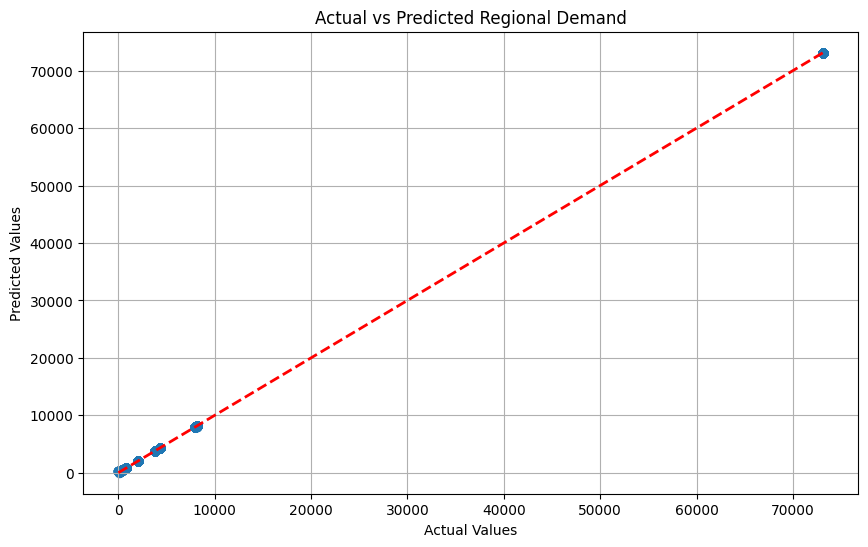


Final Gradient Boosting model saved as 'final_gradient_boosting_model.pkl'.
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   8.7s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   9.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  17.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=150; total time=  27.4s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=  10.5s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=  10.8s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  20.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=  32.3s
[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  12.2s
[CV] END ...learning_rate=0.01, max_depth=7, n_estimators=50; total time=  11.2s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=  22.3s
[CV] END ..learning_rate=0.01, m

In [56]:
# Step 3: Validate Phase 1 Model (if available)
if phase1_model:
    # Validate the Phase 1 model on aligned data
    print("\nValidating Phase 1 Model on Aligned Phase 2 Dataset...")
    phase1_predictions = phase1_model.predict(X_test_phase1)
    phase1_mae = mean_absolute_error(y_test, phase1_predictions)
    phase1_mse = mean_squared_error(y_test, phase1_predictions)
    phase1_r2 = r2_score(y_test, phase1_predictions)
    print(f"Phase 1 Model Metrics on Phase 2 Test Data:\nMAE: {phase1_mae:.4f}, MSE: {phase1_mse:.4f}, R²: {phase1_r2:.4f}")

# Step 4: Train a Gradient Boosting Model for Dynamic Pricing
print("\n--- Training Gradient Boosting Model ---")
gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb_model, gb_param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_gb_model = grid_search.best_estimator_
print(f"\nBest Gradient Boosting Model Parameters: {grid_search.best_params_}")

# Step 5: Evaluate the Gradient Boosting Model
print("\n--- Evaluating Gradient Boosting Model ---")
gb_predictions = best_gb_model.predict(X_test)
gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)
print(f"Gradient Boosting Model Metrics:\nMAE: {gb_mae:.4f}, MSE: {gb_mse:.4f}, R²: {gb_r2:.4f}")

# Step 6: Visualize Predictions
print("\n--- Visualizing Predictions ---")
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gb_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Regional Demand')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Step 7: Save the Gradient Boosting Model
joblib.dump(best_gb_model, 'final_gradient_boosting_model.pkl')
print("\nFinal Gradient Boosting model saved as 'final_gradient_boosting_model.pkl'.")


In [57]:
phase1_metrics = {
        'MAE': mean_absolute_error(y_test, phase1_predictions),
        'MSE': mean_squared_error(y_test, phase1_predictions),
        'R²': r2_score(y_test, phase1_predictions)
    }

gb_metrics = {
    'MAE': mean_absolute_error(y_test, gb_predictions),
    'MSE': mean_squared_error(y_test, gb_predictions),
    'R²': r2_score(y_test, gb_predictions)
}

In [58]:
# Compare Metrics
print("\n--- Model Performance Comparison ---")
if phase1_model:
    print(f"Phase 1 Model vs Gradient Boosting Model:")
    print(f"MAE: {phase1_metrics['MAE']:.4f} vs {gb_metrics['MAE']:.4f}")
    print(f"MSE: {phase1_metrics['MSE']:.4f} vs {gb_metrics['MSE']:.4f}")
    print(f"R²: {phase1_metrics['R²']:.4f} vs {gb_metrics['R²']:.4f}")
else:
    print("Comparison unavailable as Phase 1 Model is not loaded.")


--- Model Performance Comparison ---
Phase 1 Model vs Gradient Boosting Model:
MAE: 0.1633 vs 0.8429
MSE: 8.6647 vs 100.0935
R²: 1.0000 vs 1.0000


**Feature Contribution Analysis**

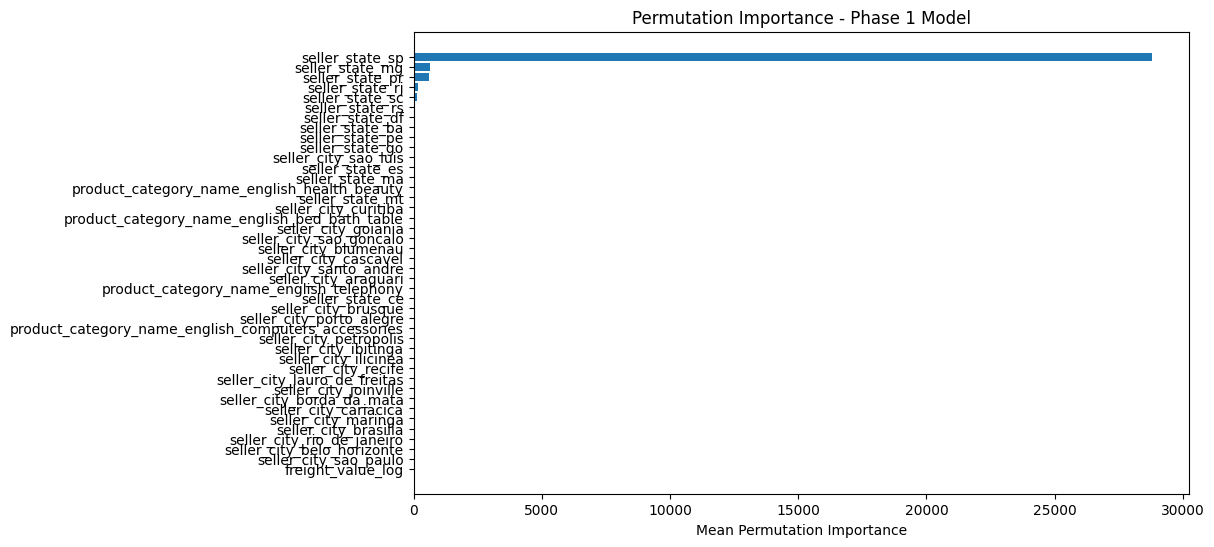

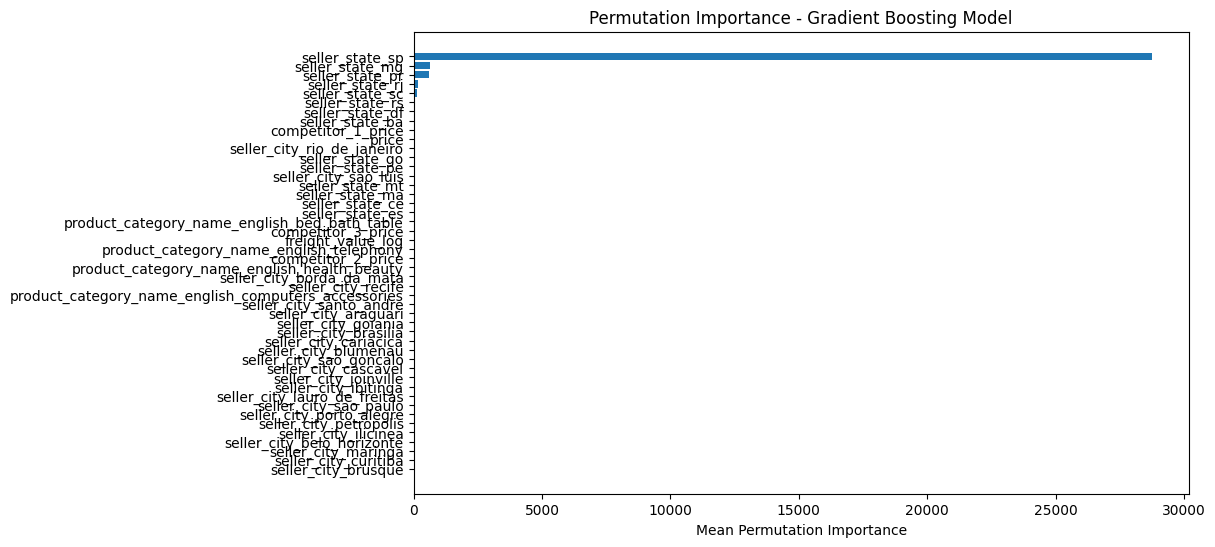

 98%|===================| 20203/20563 [00:50<00:00]        


--- SHAP Summary Plot for Gradient Boosting ---


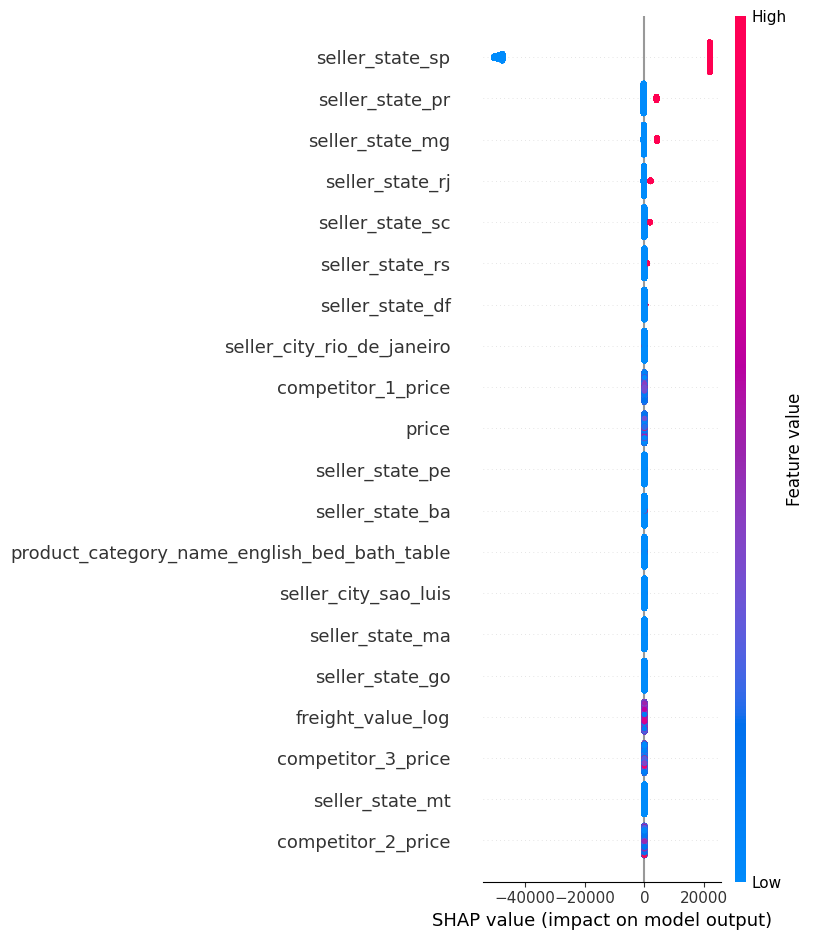

In [59]:
from sklearn.inspection import permutation_importance
import shap
import matplotlib.pyplot as plt

# Feature Importance (Permutation)
def plot_permutation_importance(model, X, y, feature_names, title):
    result = permutation_importance(model, X, y, scoring='neg_mean_absolute_error', n_repeats=5, random_state=42)
    sorted_idx = result.importances_mean.argsort()

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names[sorted_idx], result.importances_mean[sorted_idx])
    plt.xlabel("Mean Permutation Importance")
    plt.title(title)
    plt.show()

# Random Forest Feature Importance
plot_permutation_importance(
    phase1_model,
    X_test_phase1,
    y_test,
    phase1_feature_names,
    title="Permutation Importance - Phase 1 Model"
)

# Gradient Boosting Feature Importance
plot_permutation_importance(
    best_gb_model,
    X_test,
    y_test,
    X_test_df.columns,
    title="Permutation Importance - Gradient Boosting Model"
)

# SHAP Analysis for Gradient Boosting
explainer = shap.Explainer(best_gb_model, X_test)
shap_values = explainer(X_test)

print("\n--- SHAP Summary Plot for Gradient Boosting ---")
shap.summary_plot(shap_values, X_test, feature_names=X_test_df.columns)


**Dynamic Pricing Algorithm**

In [11]:
import numpy as np
import pandas as pd

# Step 1: Load Processed Dataset and Phase 2 Model
dynamic_pricing_data = pd.read_csv('/kaggle/input/dynamic-pricing-with-competitor-data/dynamic_pricing_with_competitor_data.csv')

# Load Gradient Boosting Model
import joblib
phase2_model = joblib.load('/kaggle/input/phase-2-model/final_gradient_boosting_model.pkl')

# Step 2: Predict Regional Demand using Gradient Boosting Model
X_features = dynamic_pricing_data.drop(columns=['regional_demand', 'order_id'])
predicted_demand = phase2_model.predict(X_features)

# Add predictions back to the dataset
dynamic_pricing_data['predicted_demand'] = predicted_demand

# Step 3: Define Dynamic Pricing Algorithm
def calculate_optimal_price(row, base_price, margin_target=0.2, competitor_weight=0.5, high_demand_threshold=5000, low_demand_threshold=2000):
    """
    Calculates the optimal price based on demand predictions, competitor prices, and business constraints.
    
    Parameters:
    - row: Single row of the dataset.
    - base_price: The current price of the product.
    - margin_target: Desired profit margin (default: 20%).
    - competitor_weight: Weight assigned to competitor prices (default: 0.5).
    - high_demand_threshold: Threshold to consider demand as high.
    - low_demand_threshold: Threshold to consider demand as low.
    
    Returns:
    - optimal_price: The recommended price.
    """
    # Average competitor price
    competitor_avg_price = np.mean([row['competitor_1_price'], 
                                    row['competitor_2_price'], 
                                    row['competitor_3_price']])
    predicted_demand = row['predicted_demand']

    # Dynamically adjust margin target based on demand
    dynamic_margin = margin_target * (1 + (predicted_demand / high_demand_threshold))
    
    # Adjust pricing based on demand level
    if predicted_demand >= high_demand_threshold:
        # High demand: price slightly higher than base but below competitors
        optimal_price = min(base_price * (1 + dynamic_margin * 0.5), competitor_avg_price * 0.9)
    elif predicted_demand <= low_demand_threshold:
        # Low demand: price slightly lower than base price to boost demand
        optimal_price = max(base_price * (1 - dynamic_margin * 0.2), competitor_avg_price * 1.1)
    else:
        # Moderate demand: balanced pricing between base and competitors
        optimal_price = (base_price * (1 + dynamic_margin) + competitor_avg_price) / 2
    
    # Ensure minimum profit margin
    min_profit_price = base_price * (1 + margin_target)
    return round(max(optimal_price, min_profit_price), 2)

# Step 4: Apply the Pricing Algorithm
base_price = dynamic_pricing_data['price']
dynamic_pricing_data['optimal_price'] = dynamic_pricing_data.apply(
    lambda row: calculate_optimal_price(row, base_price=row['price']), axis=1
)

# Step 5: Evaluate Pricing Strategy
# Revenue with the original prices
original_revenue = np.sum(dynamic_pricing_data['price'] * dynamic_pricing_data['predicted_demand'])

# Revenue with the new optimal prices
optimal_revenue = np.sum(dynamic_pricing_data['optimal_price'] * dynamic_pricing_data['predicted_demand'])

print("\n--- Pricing Strategy Evaluation ---")
print(f"Original Revenue: {original_revenue:.2f}")
print(f"Optimal Revenue: {optimal_revenue:.2f}")

# Save the dataset with optimal prices
dynamic_pricing_data.to_csv('dynamic_pricing_with_optimal_prices.csv', index=False)
print("\nDataset with optimal prices saved as 'dynamic_pricing_with_optimal_prices.csv'.")


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(



--- Pricing Strategy Evaluation ---
Original Revenue: 85511117186.96
Optimal Revenue: 102617153744.88

Dataset with optimal prices saved as 'dynamic_pricing_with_optimal_prices.csv'.


In [21]:
dynamic_pricing_data[['product_category_name_english','price','optimal_price','predicted_demand', 'regional_demand']].groupby('product_category_name_english')

In [23]:
# Grouping and collecting unique values for each product category
grouped_data = dynamic_pricing_data.groupby('product_category_name_english').agg({
    'price': lambda x: list(x.unique()),                # Unique original prices
    'optimal_price': lambda x: list(x.unique()),        # Unique optimal prices
    'predicted_demand': lambda x: list(x.unique()),     # Unique predicted demand values
    'regional_demand': lambda x: list(x.unique())       # Unique regional demand values
}).reset_index()

# Rename columns for better readability
grouped_data.columns = [
    'Product Category', 
    'Unique Original Prices', 
    'Unique Optimal Prices', 
    'Unique Predicted Demands', 
    'Unique Regional Demands'
]

# Display the grouped data
print(grouped_data)


              Product Category  \
0   agro_industry_and_commerce   
1             air_conditioning   
2                          art   
3        arts_and_craftmanship   
4                        audio   
..                         ...   
66                  stationery   
67      tablets_printing_image   
68                   telephony   
69                        toys   
70               watches_gifts   

                               Unique Original Prices  \
0   [410.0, 21.99, 39.9, 29.5, 425.0, 412.0, 429.0...   
1   [186.9, 190.0, 412.0, 59.9, 149.9, 144.0, 700....   
2   [110.99, 129.99, 99.99, 97.5, 69.99, 6499.0, 1...   
3   [9.8, 12.9, 39.9, 19.87, 21.99, 238.0, 126.49,...   
4   [89.0, 89.9, 55.0, 586.0, 14.9, 598.99, 76.89,...   
..                                                ...   
66  [19.9, 89.9, 99.0, 49.9, 39.0, 119.0, 95.0, 68...   
67  [69.9, 49.9, 14.9, 54.9, 99.0, 29.99, 52.0, 28...   
68  [27.99, 76.0, 22.99, 24.89, 45.0, 29.99, 759.0...   
69  [38.25, 84.9, 119

In [24]:
# Load the original dataset (ensure it contains 'order_id' and 'product_category_name_english')
original_df = pd.read_csv('/kaggle/input/final-merged-dataset/final_merged_df.csv')

In [25]:
original_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'product_id', 'seller_id', 'price', 'freight_value', 'payment_type',
       'payment_value', 'product_category_name',
       'product_category_name_english', 'seller_city', 'seller_state',
       'review_score'],
      dtype='object')

In [12]:
# Load the original dataset (ensure it contains 'order_id' and 'product_category_name_english')
original_df = pd.read_csv('/kaggle/input/final-merged-dataset/final_merged_df.csv')

# Merge 'product_category_name_english' into the dynamic pricing dataset
if 'order_id' in original_df.columns and 'order_id' in dynamic_pricing_data.columns:
    dynamic_pricing_data = dynamic_pricing_data.merge(
        original_df[['order_id', 'product_category_name_english']],
        on='order_id',
        how='left'  # Keep all rows in dynamic_pricing_data
    )
    print("Product category column successfully added.")
else:
    print("Error: 'order_id' column is missing in one of the datasets.")

# Check for missing categories after the merge
missing_categories = dynamic_pricing_data['product_category_name_english'].isnull().sum()
if missing_categories > 0:
    print(f"Warning: {missing_categories} rows are missing product category information.")
else:
    print("All rows successfully matched with product categories.")


Product category column successfully added.


In [13]:
dynamic_pricing_data.columns

Index(['seller_state_sp', 'seller_state_mg', 'seller_state_pr',
       'freight_value_log', 'seller_state_rj', 'seller_state_sc',
       'seller_city_sao_paulo', 'seller_state_rs', 'seller_city_curitiba',
       'seller_city_rio_de_janeiro', 'seller_city_belo_horizonte',
       'seller_city_maringa', 'seller_state_df', 'seller_city_brasilia',
       'seller_state_ba', 'seller_state_go', 'seller_city_porto_alegre',
       'seller_state_ma', 'seller_state_pe', 'seller_city_sao_luis',
       'seller_city_ibitinga', 'seller_city_petropolis', 'seller_state_es',
       'product_category_name_english_computers_accessories',
       'seller_city_joinville', 'seller_city_lauro_de_freitas',
       'seller_city_recife', 'seller_city_ilicinea',
       'product_category_name_english_health_beauty',
       'seller_city_borda_da_mata', 'seller_city_cariacica',
       'seller_city_brusque', 'seller_city_sao_goncalo',
       'seller_city_blumenau', 'product_category_name_english_bed_bath_table',
       

In [14]:
# Summarize Prices by Product Category
price_summary = dynamic_pricing_data.groupby('product_category_name_english').agg({
    'price': ['mean'],  # Original Price Statistics
    'competitor_1_price': ['mean'],   # Competitor 1 Statistics
    'competitor_2_price': ['mean'],   # Competitor 2 Statistics
    'competitor_3_price': ['mean'],   # Competitor 3 Statistics
    'optimal_price': ['mean'],  # Optimal Price Statistics
    'predicted_demand': ['mean']  # Predicted Demand
}).reset_index()

# Rename Columns for Readability
price_summary.columns = [
    'Product Category', 
    'Avg Original Price',
    'Avg Competitor 1 Price', 'Avg Competitor 2 Price', 'Avg Competitor 3 Price',
    'Avg Optimal Price',
    'Avg Predicted Demand'
]

# Display Summary Table
print("\n--- Product Category Pricing Summary ---\n")
print(price_summary)

# Save the summary to a CSV file for further use
price_summary.to_csv('product_category_pricing_summary.csv', index=False)
print("\nProduct category pricing summary saved as 'product_category_pricing_summary.csv'.")



--- Product Category Pricing Summary ---

              Product Category  Avg Original Price  Avg Competitor 1 Price  \
0   agro_industry_and_commerce          280.084854              281.458976   
1             air_conditioning          180.126996              178.337138   
2                          art          106.600375              106.442742   
3        arts_and_craftmanship           68.060000               66.982003   
4                        audio          141.386010              141.405836   
..                         ...                 ...                     ...   
66                  stationery           92.302006               92.433773   
67      tablets_printing_image           90.699063               91.308514   
68                   telephony           69.020773               69.039260   
69                        toys          114.570853              114.720718   
70               watches_gifts          198.494448              198.520358   

    Avg Competitor 2

**Demand-Price Relationship Analysis**

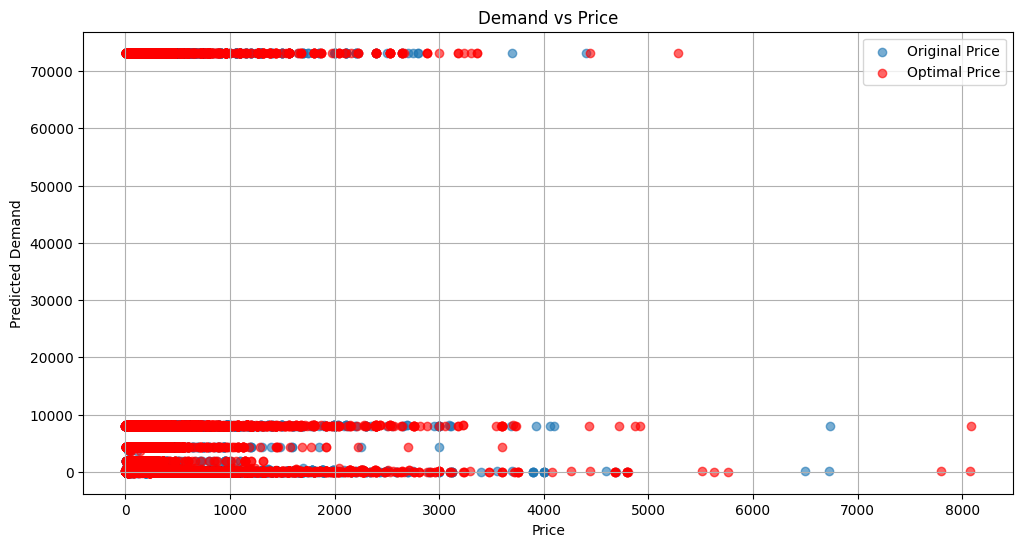

In [15]:
import matplotlib.pyplot as plt

# Plot demand vs original price
plt.figure(figsize=(12, 6))
plt.scatter(dynamic_pricing_data['price'], dynamic_pricing_data['predicted_demand'], alpha=0.6, label="Original Price")
plt.scatter(dynamic_pricing_data['optimal_price'], dynamic_pricing_data['predicted_demand'], alpha=0.6, label="Optimal Price", color='r')
plt.xlabel("Price")
plt.ylabel("Predicted Demand")
plt.title("Demand vs Price")
plt.legend()
plt.grid(True)
plt.show()


**Revenue Comparison Across Product Categories**

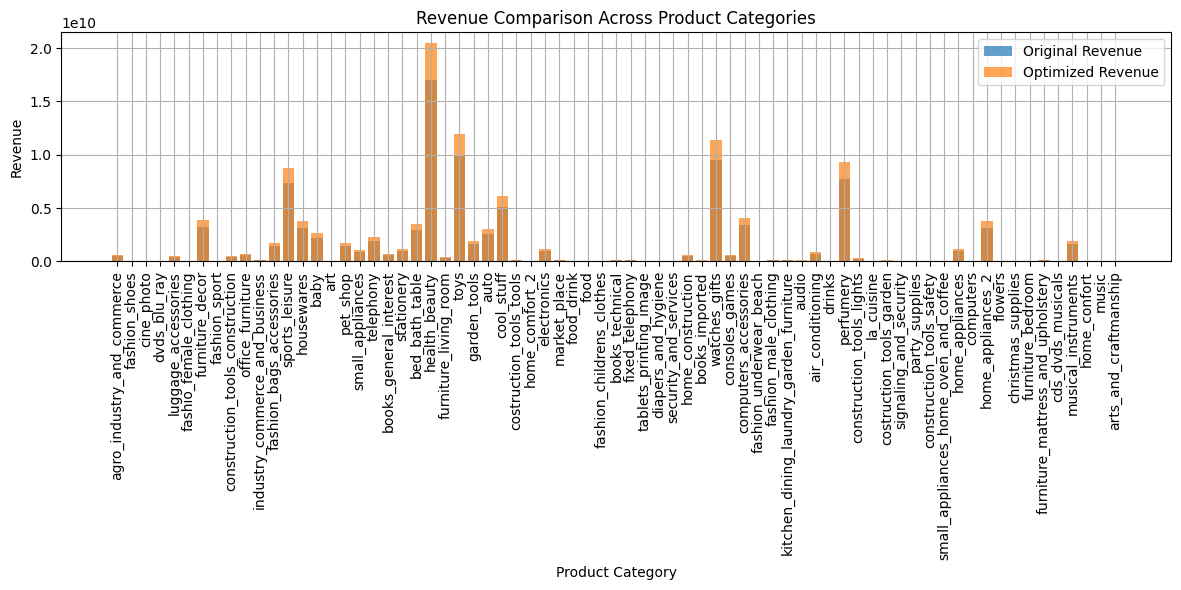

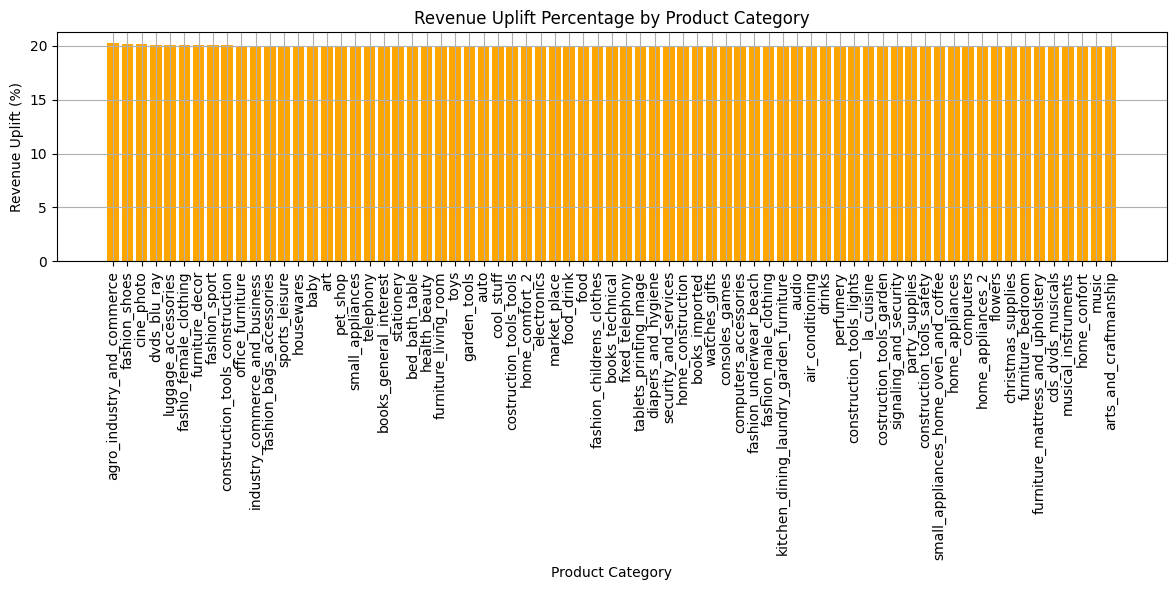

In [16]:
import matplotlib.pyplot as plt

# Group by product category and calculate revenues
category_revenue = dynamic_pricing_data.groupby('product_category_name_english').agg({
    'price': lambda x: np.sum(x * dynamic_pricing_data.loc[x.index, 'predicted_demand']),
    'optimal_price': lambda x: np.sum(x * dynamic_pricing_data.loc[x.index, 'predicted_demand'])
}).reset_index()

category_revenue.columns = ['Product Category', 'Original Revenue', 'Optimized Revenue']

# Calculate revenue uplift percentage
category_revenue['Revenue Uplift (%)'] = ((category_revenue['Optimized Revenue'] - category_revenue['Original Revenue']) / category_revenue['Original Revenue']) * 100

# Sort by revenue uplift for better visualization
category_revenue = category_revenue.sort_values(by='Revenue Uplift (%)', ascending=False)

# Plot revenue comparison
plt.figure(figsize=(12, 6))
plt.bar(category_revenue['Product Category'], category_revenue['Original Revenue'], label='Original Revenue', alpha=0.7)
plt.bar(category_revenue['Product Category'], category_revenue['Optimized Revenue'], label='Optimized Revenue', alpha=0.7)
plt.xticks(rotation=90)
plt.xlabel('Product Category')
plt.ylabel('Revenue')
plt.title('Revenue Comparison Across Product Categories')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot revenue uplift
plt.figure(figsize=(12, 6))
plt.bar(category_revenue['Product Category'], category_revenue['Revenue Uplift (%)'], color='orange')
plt.xticks(rotation=90)
plt.xlabel('Product Category')
plt.ylabel('Revenue Uplift (%)')
plt.title('Revenue Uplift Percentage by Product Category')
plt.grid(True)
plt.tight_layout()
plt.show()


**Pricing Impact on Market Share**

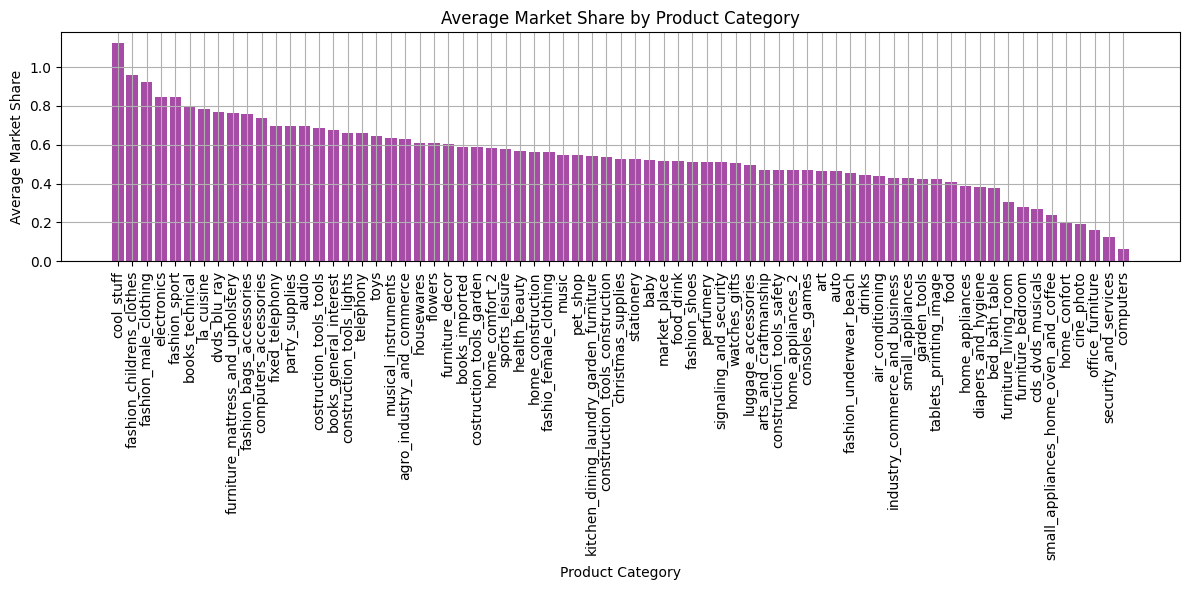

In [10]:
# Estimate market share
dynamic_pricing_data['market_share'] = dynamic_pricing_data['predicted_demand'] / (
    dynamic_pricing_data['predicted_demand'] +
    np.mean([
        dynamic_pricing_data['competitor_1_price'],
        dynamic_pricing_data['competitor_2_price'],
        dynamic_pricing_data['competitor_3_price']
    ], axis=0)
)

# Average market share by product category
market_share_summary = dynamic_pricing_data.groupby('product_category_name_english').agg({
    'market_share': 'mean'
}).reset_index()

# Sort by market share for visualization
market_share_summary = market_share_summary.sort_values(by='market_share', ascending=False)

# Plot market share by product category
plt.figure(figsize=(12, 6))
plt.bar(market_share_summary['product_category_name_english'], market_share_summary['market_share'], color='purple', alpha=0.7)
plt.xticks(rotation=90)
plt.xlabel('Product Category')
plt.ylabel('Average Market Share')
plt.title('Average Market Share by Product Category')
plt.grid(True)
plt.tight_layout()
plt.show()


**Visualizing Competitor Price Dynamics**

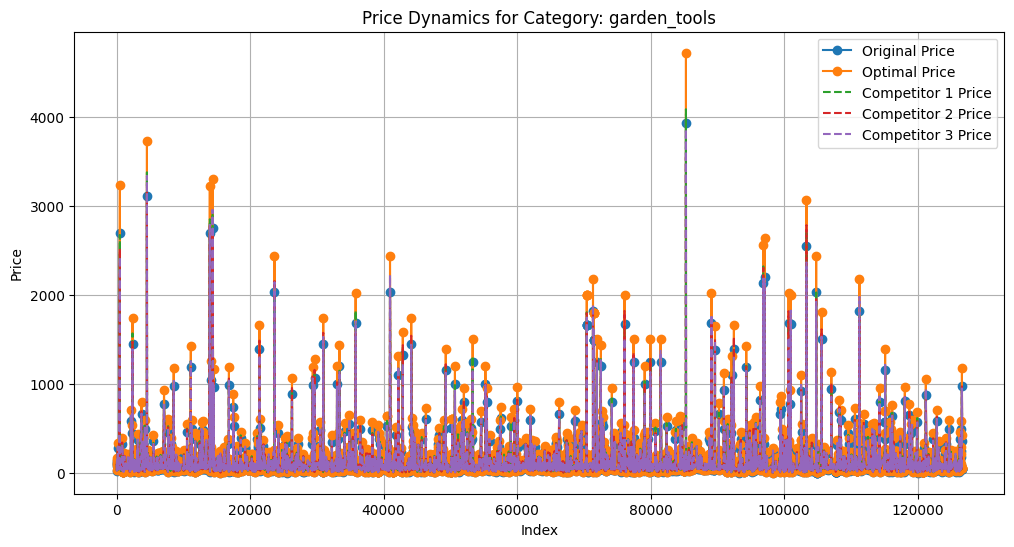

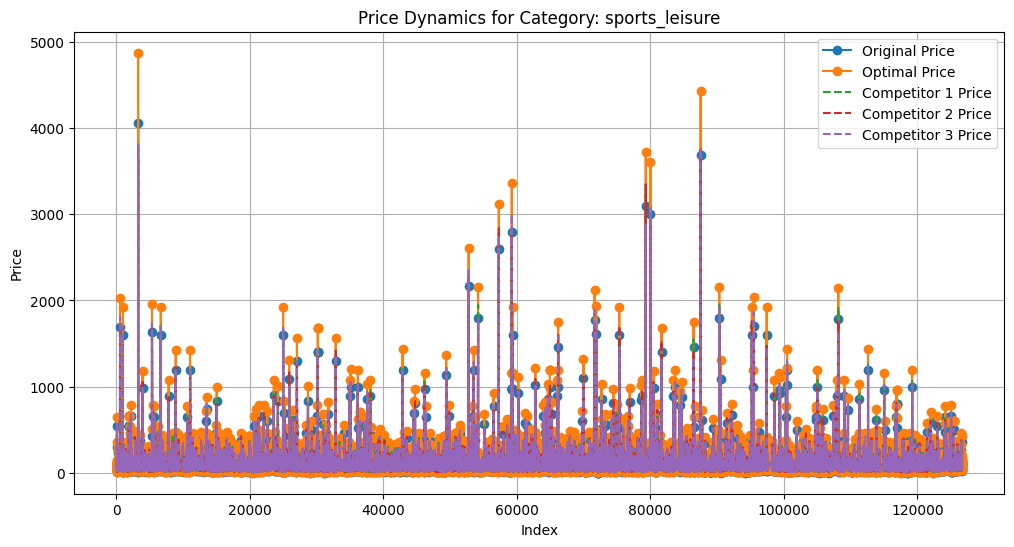

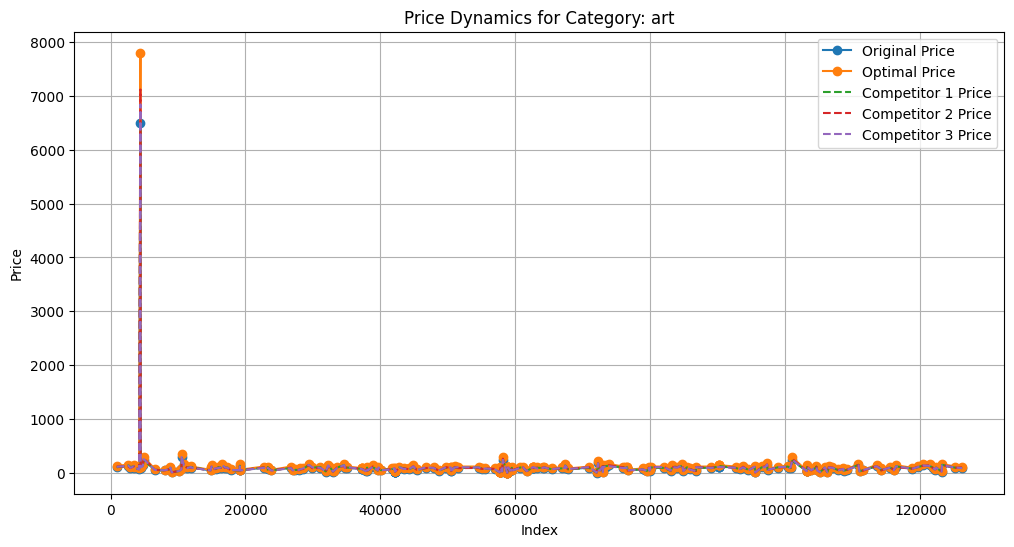

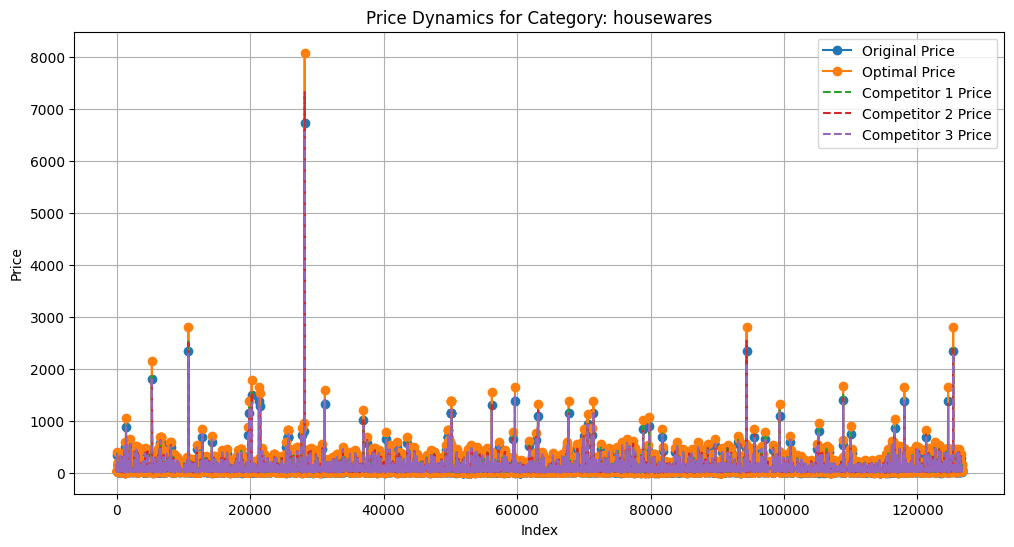

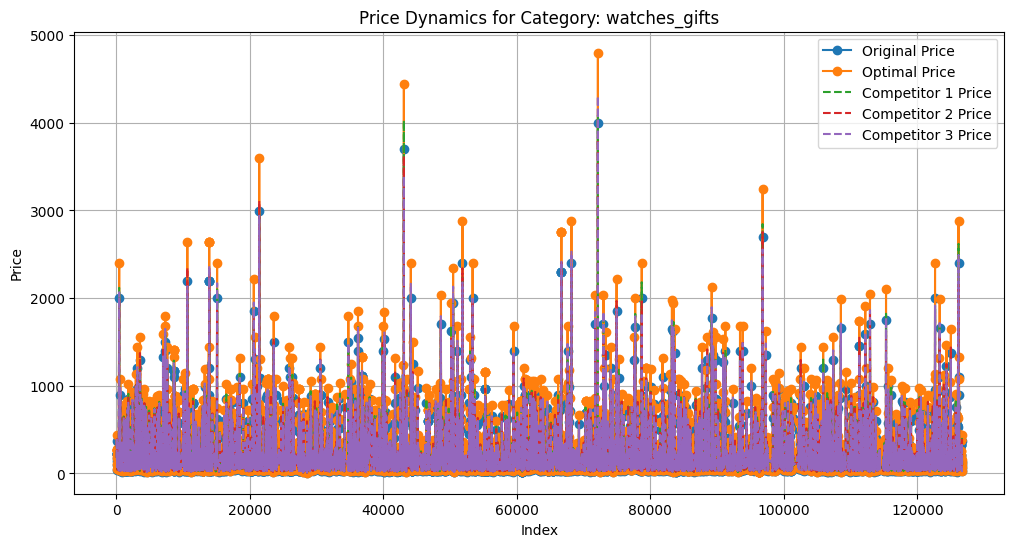

In [6]:
sample_categories = dynamic_pricing_data['product_category_name_english'].sample(5, random_state=42).unique()

for category in sample_categories:
    subset = dynamic_pricing_data[dynamic_pricing_data['product_category_name_english'] == category]
    plt.figure(figsize=(12, 6))
    plt.plot(subset['price'], label="Original Price", marker='o')
    plt.plot(subset['optimal_price'], label="Optimal Price", marker='o')
    plt.plot(subset['competitor_1_price'], label="Competitor 1 Price", linestyle='--')
    plt.plot(subset['competitor_2_price'], label="Competitor 2 Price", linestyle='--')
    plt.plot(subset['competitor_3_price'], label="Competitor 3 Price", linestyle='--')
    plt.title(f"Price Dynamics for Category: {category}")
    plt.xlabel("Index")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


**Detailed Uplift Analysis**

In [7]:
dynamic_pricing_data['price_uplift'] = dynamic_pricing_data['optimal_price'] - dynamic_pricing_data['price']

# Top 10 products with the highest price uplift
top_uplift = dynamic_pricing_data.nlargest(10, 'price_uplift')
print("\nTop 10 Products with Highest Price Uplift:")
print(top_uplift[['product_category_name_english', 'price', 'optimal_price', 'price_uplift']])

# Top 10 products with the lowest price uplift
low_uplift = dynamic_pricing_data.nsmallest(10, 'price_uplift')
print("\nTop 10 Products with Lowest Price Uplift:")
print(low_uplift[['product_category_name_english', 'price', 'optimal_price', 'price_uplift']])



Top 10 Products with Highest Price Uplift:
      product_category_name_english    price  optimal_price  price_uplift
28171                    housewares  6735.00        8082.00       1347.00
36126                     computers  6729.00        8074.80       1345.80
4435                            art  6499.00        7798.80       1299.80
67536              small_appliances  4799.00        5758.80        959.80
51408              small_appliances  4690.00        5628.00        938.00
51425                     computers  4590.00        5508.00        918.00
14959           musical_instruments  4399.87        5279.84        879.97
24843                consoles_games  4099.99        4919.99        820.00
3277                 sports_leisure  4059.00        4870.80        811.80
72131                 watches_gifts  3999.90        4799.88        799.98

Top 10 Products with Lowest Price Uplift:
          product_category_name_english  price  optimal_price  price_uplift
66644             compu